In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(test_size=0.2, img_size=360,Gray2RGB=True)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(3321, 360, 360, 3)
(3321, 15)
(831, 360, 360, 3)
(831, 15)


In [4]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# model.add(Flatten())

model.add(GlobalAveragePooling2D())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 360, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 360, 360, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 360, 360, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 180, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 180, 64)      256       
__________

In [5]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-4)

model_path = './saved_models/CNN_0510001.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=6, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
#model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 64
aug_ratio = 2
epochs = 400
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint,earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/400
102/103 [============================>.] - ETA: 1s - loss: 2.7506 - acc: 0.1483
Epoch 00001: val_loss improved from inf to 2.73832, saving model to ./saved_models/CNN_0510001.h5
103/103 [==============================] - 145s 1s/step - loss: 2.7494 - acc: 0.1483 - val_loss: 2.7383 - val_acc: 0.2070
Epoch 2/400
102/103 [============================>.] - ETA: 1s - loss: 2.5001 - acc: 0.2191
Epoch 00002: val_loss did not improve from 2.73832
103/103 [==============================] - 137s 1s/step - loss: 2.4994 - acc: 0.2194 - val_loss: 6.8177 - val_acc: 0.1408
Epoch 3/400
102/103 [============================>.] - ETA: 1s - loss: 2.3642 - acc: 0.2293
Epoch 00003: val_loss did not improve from 2.73832
103/103 [==============================] - 136s 1s/step - loss: 2.3641 - acc: 0.2292 - val_loss: 12.6516 - val_acc: 0.2130
Epoch 4/400
102/103 [============================>.] - ETA: 1s - loss: 2.2712 - acc: 0.2347
Epoch 00004: val_loss did not improve from 2.73832
103/103 [=====

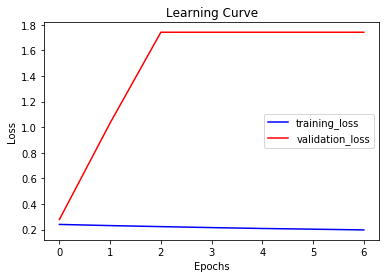

In [6]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, 'b', label="training_loss")
plt.plot(val_loss, 'r', label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

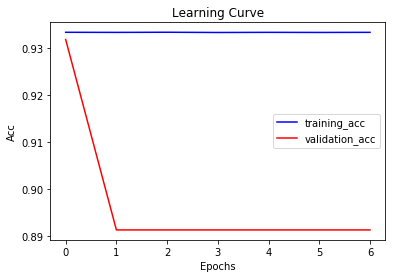

In [7]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, 'b', label="training_acc")
plt.plot(val_acc, 'r', label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(3321, 360, 360, 3)
(3321, 15)
(831, 360, 360, 3)
(831, 15)


In [9]:
X_test, X_id = load_test_data(Gray2RGB=True, img_size=360)
print(X_test.shape)

(438, 360, 360, 3)


In [10]:
print(X_valid.shape)

(831, 360, 360, 3)


In [11]:
model_path = './saved_models/CNN_0510001.h5'.format(model_name)
model = load_model(model_path)

#scores = model.evaluate(X_valid, y_valid, verbose=1)
#print('Validation loss:', scores[0])
#print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('CNN_0510001.csv'.format(model_name), index=False)

In [ ]:
#X_train

In [ ]:
#X_test

In [ ]:
pp

In [9]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 128)     0         
__________

In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
166/167 [============================>.] - ETA: 0s - loss: 2.5018 - acc: 0.1956
Epoch 00001: val_loss improved from inf to 3.03830, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 15s 89ms/step - loss: 2.5013 - acc: 0.1955 - val_loss: 3.0383 - val_acc: 0.0569
Epoch 2/200
166/167 [============================>.] - ETA: 0s - loss: 2.0136 - acc: 0.3723
Epoch 00002: val_loss did not improve from 3.03830
167/167 [==============================] - 11s 66ms/step - loss: 2.0137 - acc: 0.3712 - val_loss: 3.1039 - val_acc: 0.0569
Epoch 3/200
166/167 [============================>.] - ETA: 0s - loss: 1.8644 - acc: 0.4287
Epoch 00003: val_loss improved from 3.03830 to 2.58687, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 11s 66ms/step - loss: 1.8619 - acc: 0.4307 - val_loss: 2.5869 - val_acc: 0.1639
Epoch 4/200
166/167 [============================>.] - ETA

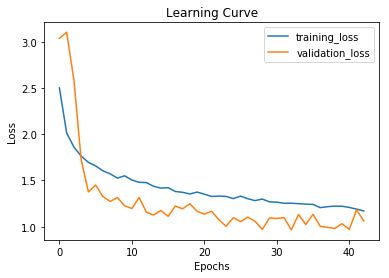

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

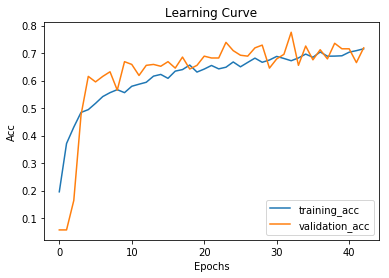

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 0.9649896470200656
Validation accuracy: 0.775919732242125
